# Jupyter Notebook for BigQuery

In [1]:
import google.cloud.bigquery
import pandas as pd

# define the project and database
PROJECT = 'ozkary-de-101'
DATASET = 'mta_data'

### Set the API client and project information

In [2]:
# using the bigquery client library 
client = google.cloud.bigquery.Client()
dataset_ref = client.dataset(DATASET, project=PROJECT)

# define a run query function
def run_query(sql):
    query = client.query(sql)
    return query.to_dataframe()
    

### View the data that is available on the datalake by querying the external table.

In [3]:
# list the records from the external table
sql = """
SELECT * 
FROM `{}.{}.ext_turnstile`  
limit 100
""".format(PROJECT, DATASET)
# query the data using the client reference
df = run_query(sql)
print(sql)
df.head(5)



SELECT * 
FROM `ozkary-de-101.mta_data.ext_turnstile`  
limit 100



,int64_field_0,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,0,A001,R001,02-00-00,Test-Station2,456NQR,BMT,2024-01-30,15:30:00,REGULAR,31,29
1,1,A002,R002,02-00-00,Test-Station2,456NQR,BMT,2024-01-30,15:30:00,REGULAR,54,59
2,2,A002,R001,02-00-00,Test-Station1,456NQR,BMT,2024-01-30,15:30:00,REGULAR,23,24
3,3,A002,R001,02-00-00,Test-Station2,456NQR,BMT,2024-01-30,15:30:00,REGULAR,50,54
4,4,A001,R002,02-00-00,Test-Station1,456NQR,BMT,2024-01-30,15:30:00,REGULAR,8,8


### List the database objects

In [2]:
# using the bigquery client library read a list of tables 
tables = list(client.list_tables(dataset_ref))
for table in tables:
    print(table.table_id)

dim_booth
dim_station
ext_batch_turnstile
ext_streaming_turnstile
ext_turnstile
fact_stats
fact_turnstile
remote_booth_station
rpt_turnstile
stg_booth
stg_station
stg_turnstile


In [3]:
# get the tables in the system and for each table get the schema
# and print the table name and row count
for table in tables:
    table_ref = dataset_ref.table(table.table_id)
    table = client.get_table(table_ref)
    print(table.schema)

# for each table get the row count
for table in tables:
    table_ref = dataset_ref.table(table.table_id)
    table = client.get_table(table_ref)
    print(table.table_id, table.num_rows)

[SchemaField('booth_id', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('remote', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('booth_name', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('station_id', 'STRING', 'NULLABLE', None, None, (), None)]
[SchemaField('station_id', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('station_name', 'STRING', 'NULLABLE', None, None, (), None)]
[SchemaField('int64_field_0', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('CA', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('UNIT', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('SCP', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('STATION', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('LINENAME', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('DIVISION', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('DATE', 'DATE', 'NULLABLE', None, None, (), None), SchemaField('TIME', 'TIME', 'NULLABLE',

### Look at the station information


In [24]:
# read the station information
sql = """
SELECT station_id, station_name
FROM `{}.{}.dim_station`
limit 100
""".format(PROJECT, DATASET)
# query the data using the client reference
df = run_query(sql)
print(sql)
df.head()


SELECT station_id, station_name
FROM `ozkary-de-101.mta_data.dim_station`
limit 100



,station_id,station_name
0,9440f03bc95426dfed0df95d0768ebd2,BEACH 36 ST
1,2e022c4b53de34527d1a8eb5ec5f234b,MYRTLE-WILLOUGH
2,1637671c86de22714149d58244698394,LACKAWANNA
3,46d6cde2d4010f5a20dd0b3dcd8d86d7,W 4 ST-WASH SQ
4,821cb20abd9ee7e5a1358100794c0878,CLINTON-WASH AV


In [4]:
# use sql to query the latest date in the fact_turnstile table and print the result using the client reference
sql = """
SELECT max(created_dt) as max_date
FROM `{}.{}.fact_turnstile`
""".format(PROJECT, DATASET)
# query the data using the client reference
df = run_query(sql)
print(sql)
df.head()


SELECT max(created_dt) as max_date
FROM `ozkary-de-101.mta_data.fact_turnstile`



,max_date
0,2024-02-09 23:59:54+00:00


In [8]:
# define todays date using a datetime object
from datetime import datetime, timedelta

# set a variable to the current date - 1 month
last_month = datetime.today() - timedelta(days=30)
date_value = last_month.strftime('%Y-%m-%d')

# select a limit of 100 rows with the latest date
sql = """
SELECT *
FROM `{}.{}.fact_turnstile`
WHERE created_dt >= '{}'
LIMIT 100
""".format(PROJECT, DATASET, date_value)    
print(sql)
df = run_query(sql)
df.head()


SELECT *
FROM `ozkary-de-101.mta_data.fact_turnstile`
WHERE created_dt >= '2024-03-03'
LIMIT 100



,log_id,station_id,booth_id,scp,line_name,division,created_dt,entries,exits


In [11]:
# print the dataframe in a grid format
def print_df(df):
    from IPython.display import display, HTML
    display(HTML(df.head().to_html()))

In [18]:
print_df(df)

,log_id,station_id,booth_id,scp,line_name,division,created_dt,entries,exits
0,4118f048daf2a2ae16418cb9613ea131,77792700f8184bbf78ed91567285bd1d,000b1145d66ea47ba7d80e381c0d22ba,00-00-00,NQW,BMT,2023-09-27 04:00:00+00:00,7048805,12861305
1,51197d55ebc532af58ea366cd60b1144,77792700f8184bbf78ed91567285bd1d,000b1145d66ea47ba7d80e381c0d22ba,00-00-00,NQW,BMT,2023-09-27 16:00:00+00:00,7049310,12861587
2,16c770822451f5e98f8c7900c244e0a9,77792700f8184bbf78ed91567285bd1d,000b1145d66ea47ba7d80e381c0d22ba,00-00-00,NQW,BMT,2023-09-27 12:00:00+00:00,7049194,12861412
3,59699893e6e65958fc08ac0b2487f9a3,77792700f8184bbf78ed91567285bd1d,000b1145d66ea47ba7d80e381c0d22ba,00-00-00,NQW,BMT,2023-09-27 00:00:00+00:00,7048803,12861279
4,2acc35df46379b9d0ff53f86bc7b6820,77792700f8184bbf78ed91567285bd1d,000b1145d66ea47ba7d80e381c0d22ba,00-00-00,NQW,BMT,2023-09-27 08:00:00+00:00,7048959,12861343


In [13]:
# join the fact_turnstile table with the dim_station table and dim_booth table for the last three months

sql = """
SELECT station_name, booth_name, created_dt, entries, exits
FROM `{}.{}.fact_turnstile` as f
JOIN `{}.{}.dim_station` as s
ON f.station_id = s.station_id
JOIN `{}.{}.dim_booth` as b
ON f.booth_id = b.booth_id
WHERE created_dt >= '{}'
LIMIT 1000
""".format(PROJECT, DATASET, PROJECT, DATASET, PROJECT, DATASET, date_value)
df_station = run_query(sql)
print(sql)
print_df(df_station)




SELECT station_name, booth_name, created_dt, entries, exits
FROM `ozkary-de-101.mta_data.fact_turnstile` as f
JOIN `ozkary-de-101.mta_data.dim_station` as s
ON f.station_id = s.station_id
JOIN `ozkary-de-101.mta_data.dim_booth` as b
ON f.booth_id = b.booth_id
WHERE created_dt >= '2024-03-03'
LIMIT 1000



,station_name,booth_name,created_dt,entries,exits


## Get the top n stations with the most entries using the df_station dataframe

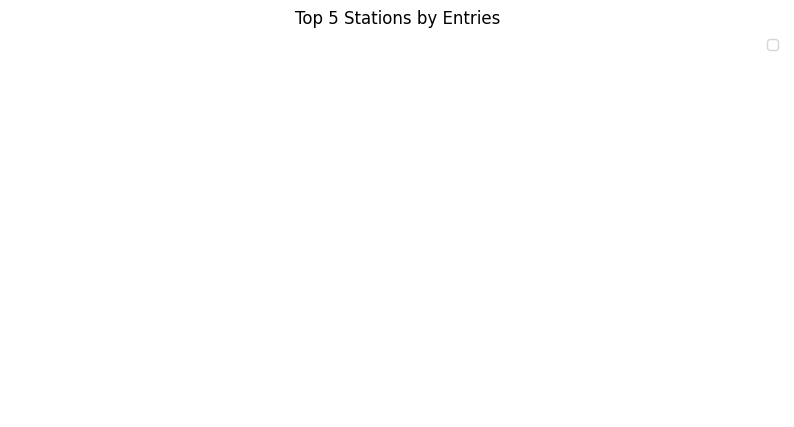

In [14]:

# get the top n stations with the most entries using the df_station dataframe
df_top_entries = df_station.groupby('station_name')['entries'].sum().reset_index().sort_values(by='entries', ascending=False).head(5)

# create a pie chart using the df_top_entries dataframe 
import matplotlib.pyplot as plt

# set the size of the pie chart
plt.figure(figsize=(10,5))

plt.pie(df_top_entries['entries'], labels=df_top_entries['station_name'], autopct='%1.1f%%')
plt.axis('equal')

# add a donut hole to the pie chart
my_circle=plt.Circle( (0,0), 0.35, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)


# add a title and legend to the pie chart
plt.title('Top 5 Stations by Entries')
plt.legend(df_top_entries['station_name'], loc='upper right')

plt.show()

